In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json
import matplotlib
import scipy
import os

matplotlib.rcParams['figure.figsize'] = [12, 5]

In [77]:
with open("../export/image_catalogue.json") as ic_file:
    image_catalog = json.load(ic_file)
    types_map = [v["type"] for k, v in sorted(image_catalog.items()) if k.isnumeric()]
    file_names_map = [os.path.basename(v["filepath"]) for k, v in sorted(image_catalog.items()) if k.isnumeric()]

In [78]:
rating_files = glob.glob("../export/*_rating.csv")
rating_files.sort()
rating_files[-1]

'../export/20230206-094318_rating.csv'

In [79]:
questions = ["Fictional/Real", "Human-made/Human-like", "Eerie/Ordinary", "Unsettling/Plain", "Creepy/Dull",
             "Hair-raising/Unemotional", "Hostile/Friendly", "Grumpy/Cheerful", "Cold-hearted/Warm-hearted"]

In [80]:
ratings = pd.read_csv(rating_files[-1], index_col=["index"],
                      names=["index", "timestamp", "img"] + questions + ["uid"])
ratings = ratings.reset_index().drop(["index"], axis=1)
ratings["type"] = [types_map[img - 1] for img in ratings["img"]]
ratings["filename"] = [file_names_map[img - 1] for img in ratings["img"]]

ratings["Fictional/Real"] -= 4
ratings["Human-made/Human-like"] -= 4
ratings["Eerie/Ordinary"] = 7 - ratings["Eerie/Ordinary"]
ratings["Unsettling/Plain"] = 7 - ratings["Unsettling/Plain"]
ratings["Creepy/Dull"] = 7 - ratings["Creepy/Dull"]
ratings["Hair-raising/Unemotional"] = 7 - ratings["Hair-raising/Unemotional"]
ratings["Hostile/Friendly"] -= 4
ratings["Grumpy/Cheerful"] -= 4
ratings["Cold-hearted/Warm-hearted"] -= 4

# Image Distribution

<AxesSubplot: >

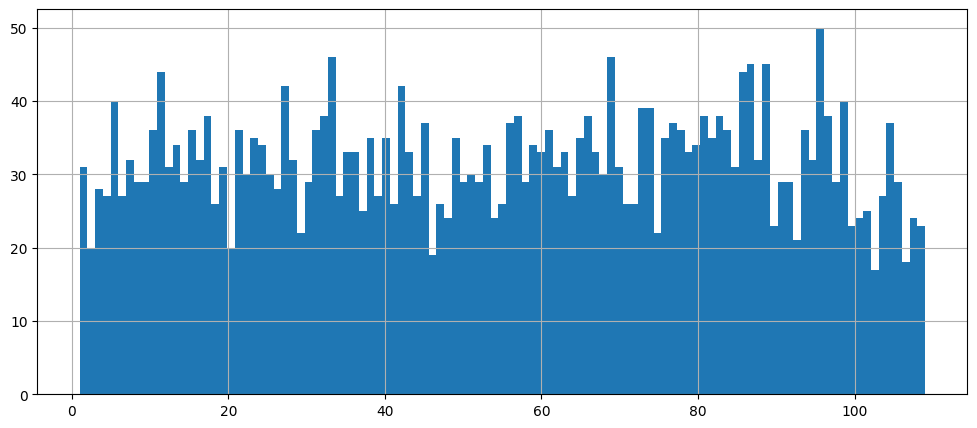

In [81]:
ratings["img"].hist(bins=ratings["img"].max())

# Ratings Distribution

In [82]:
def analyse_columns(column, ratings_param):
    fig, axes = plt.subplots(1, 4)
    fig.suptitle(column, fontsize=16)
    ratings_param[column].hist(bins=ratings_param[column].max(), ax=axes[0])
    axes[0].set_title('all')
    ratings_param[ratings_param["type"] == "human"][column].hist(bins=1 + ratings_param[column].max() - ratings_param[column].min(), ax=axes[1])
    axes[1].set_title('human')
    ratings_param[ratings_param["type"] == "semi-realistic"][column].hist(bins=1 + ratings_param[column].max() - ratings_param[column].min(),
                                                              ax=axes[2])
    axes[2].set_title('semi-realistic')
    ratings_param[ratings_param["type"] == "animated_grey"][column].hist(bins=1 + ratings_param[column].max() - ratings_param[column].min(),
                                                             ax=axes[3])
    axes[3].set_title('animated_grey')
    plt.show()
    f, f_p = scipy.stats.f_oneway(ratings_param[ratings_param["type"] == "human"][column],
                                  ratings_param[ratings_param["type"] == "semi-realistic"][column],
                                  ratings_param[ratings_param["type"] == "animated_grey"][column])
    u, u_p = scipy.stats.mannwhitneyu(ratings_param[ratings_param["type"] == "semi-realistic"][column],
                                      ratings_param[column])

    print(
        "All: {:.2f}, Human: {:.2f}, Semi Realistic: {:.2f}, Cartoon: {:.2f}, Anova p-value: {:.2f}, Mann–Whitney p-value: {:.2f} (semi vs all)".format(
            ratings_param[column].median(),
            ratings_param[ratings_param["type"] == "human"][column].median(),
            ratings_param[ratings_param["type"] == "semi-realistic"][column].median(),
            ratings_param[ratings_param["type"] == "animated_grey"][column].median(), f_p, u_p))

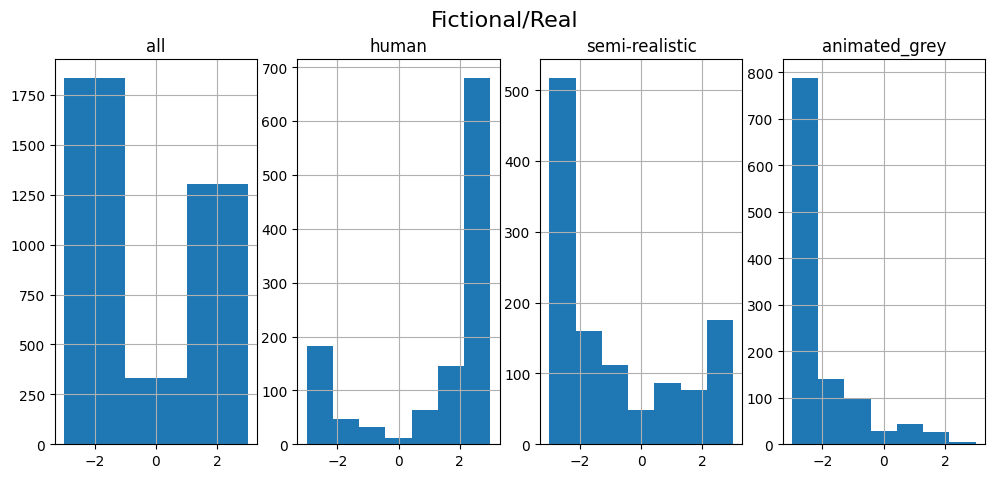

All: -2.00, Human: 3.00, Semi Realistic: -2.00, Cartoon: -3.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


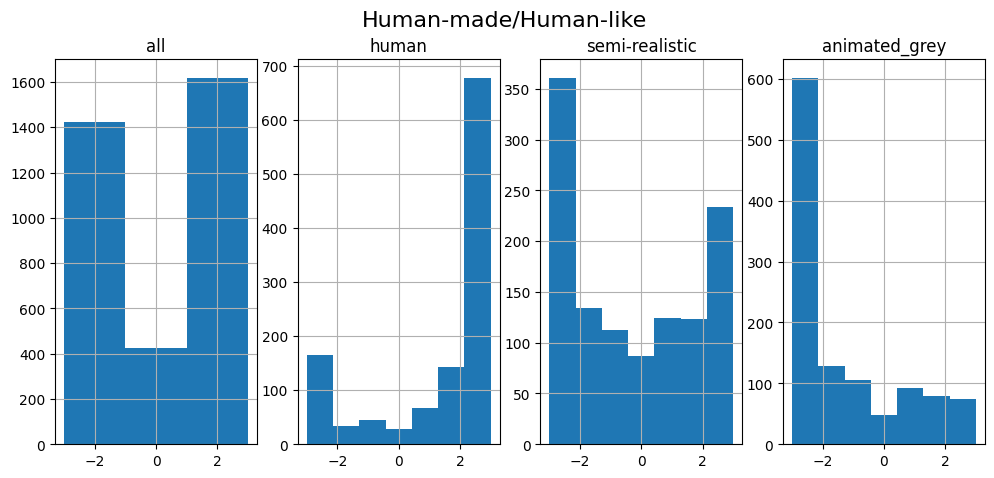

All: 0.00, Human: 3.00, Semi Realistic: -1.00, Cartoon: -3.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.01 (semi vs all)


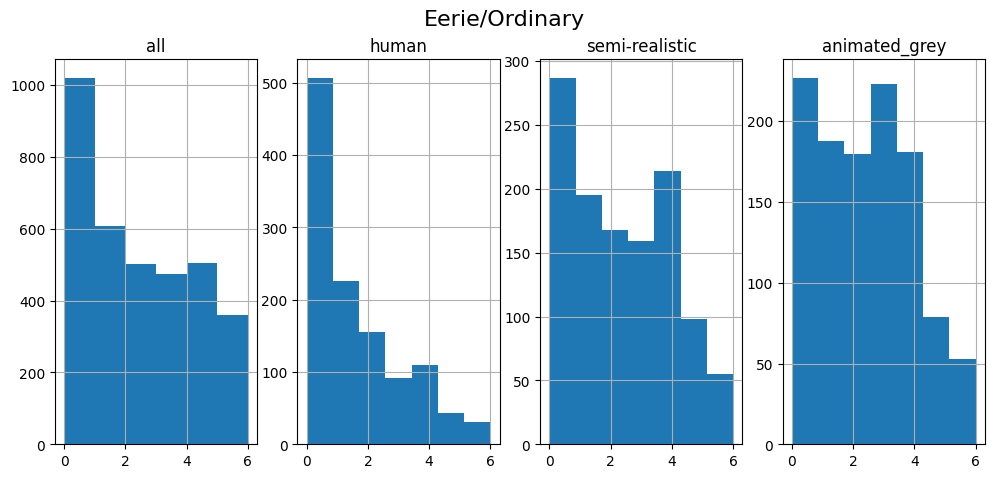

All: 2.00, Human: 1.00, Semi Realistic: 2.00, Cartoon: 2.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


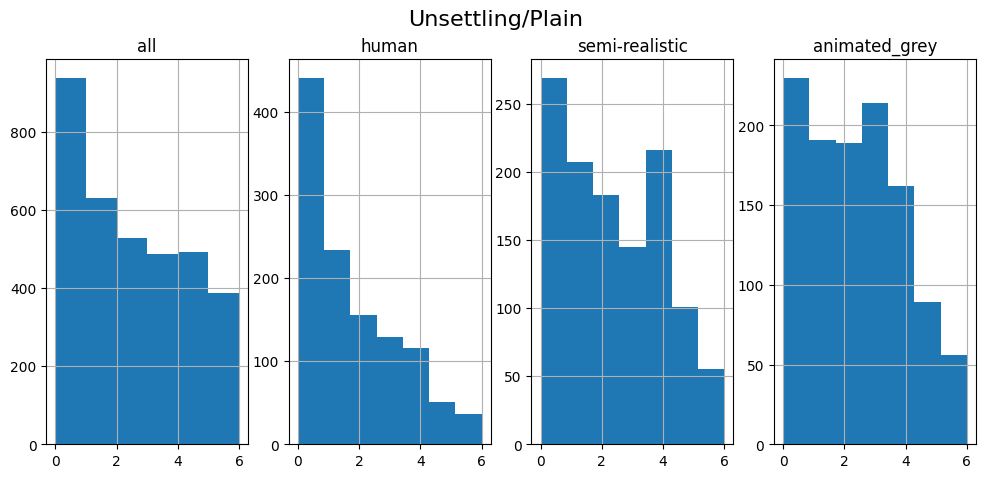

All: 2.00, Human: 1.00, Semi Realistic: 2.00, Cartoon: 2.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


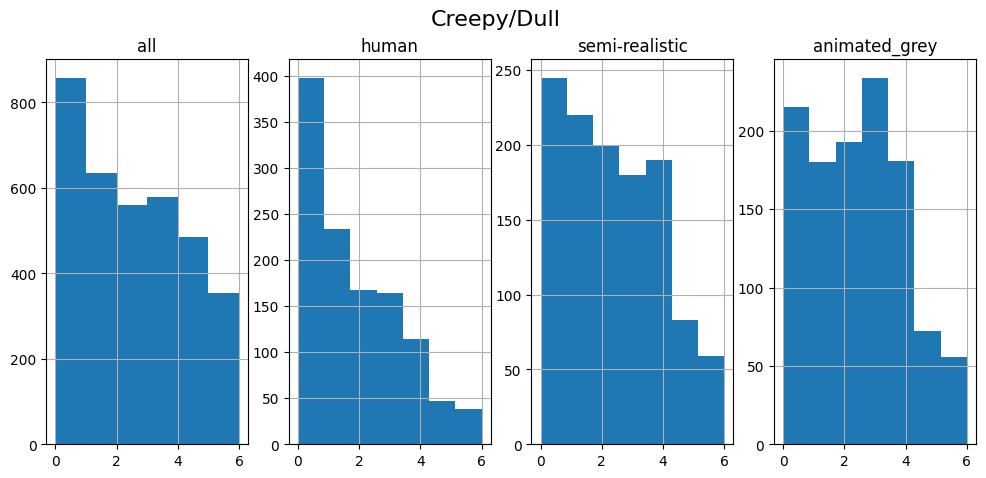

All: 2.00, Human: 1.00, Semi Realistic: 2.00, Cartoon: 2.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


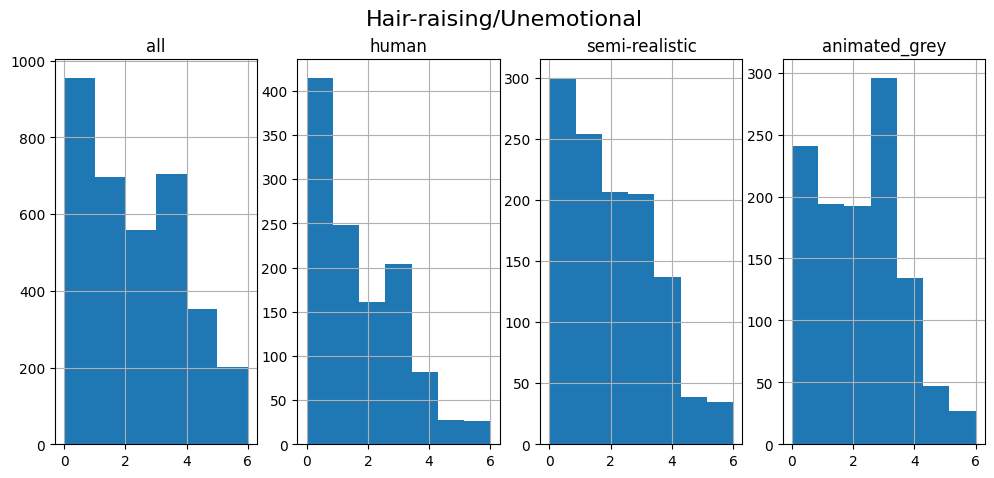

All: 2.00, Human: 1.00, Semi Realistic: 2.00, Cartoon: 2.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.43 (semi vs all)


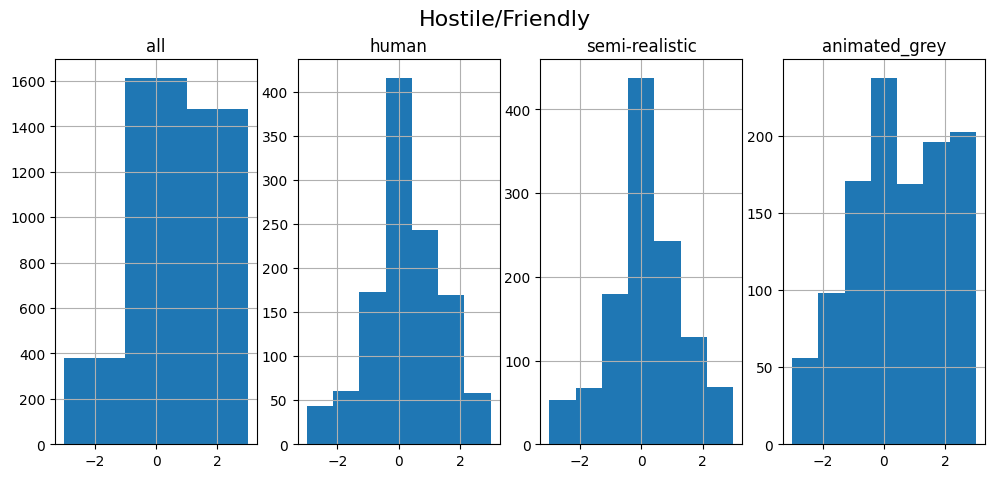

All: 0.00, Human: 0.00, Semi Realistic: 0.00, Cartoon: 1.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


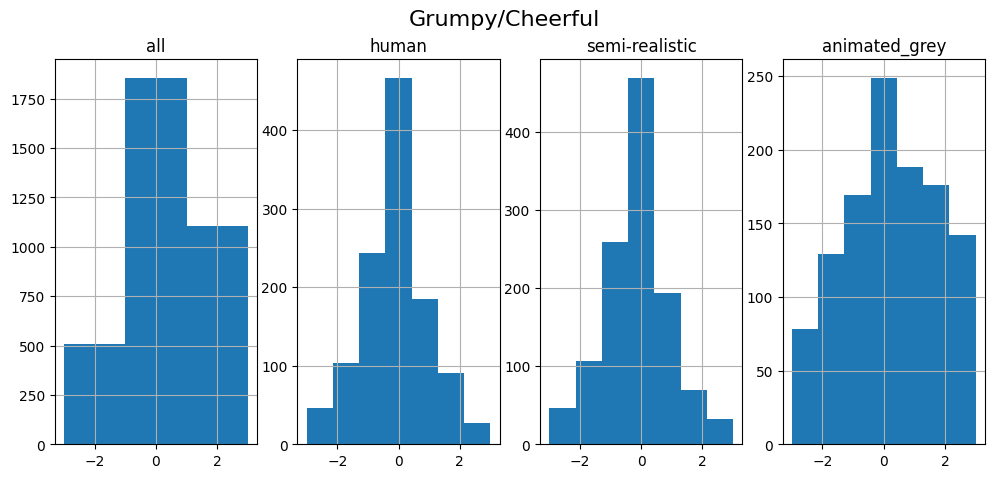

All: 0.00, Human: 0.00, Semi Realistic: 0.00, Cartoon: 0.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


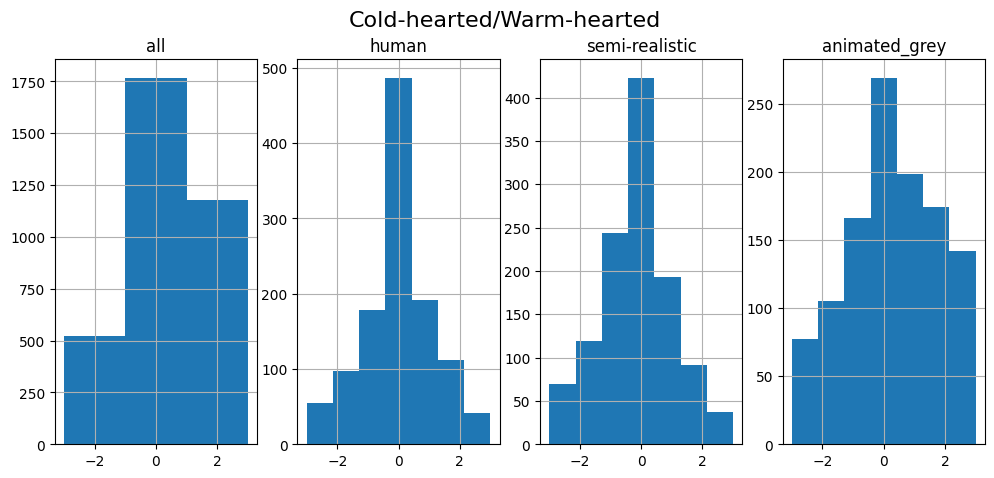

All: 0.00, Human: 0.00, Semi Realistic: 0.00, Cartoon: 0.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [83]:
for column in questions:
    analyse_columns(column, ratings)

# Exploratory Factor Analysis

In [84]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

items = ratings[questions]
chi_square_value, p_value = calculate_bartlett_sphericity(items)
print("Bartlett ’s test:")
print(chi_square_value, p_value)
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(items)
print("KMO:")
print(kmo_model)
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(items)
print("Loadings:")
print(fa.loadings_)

Bartlett ’s test:
23755.956399782557 0.0
KMO:
0.8130055448214648
Loadings:
[[-0.2036483  -0.08230182  0.86122642]
 [-0.13439766 -0.04393639  0.8746616 ]
 [ 0.81822004 -0.20216748 -0.2302272 ]
 [ 0.88688614 -0.23567151 -0.14602348]
 [ 0.88412999 -0.23840632 -0.10525668]
 [ 0.74276751 -0.16941011 -0.09625377]
 [-0.31385974  0.84604576 -0.05124578]
 [-0.13324509  0.83186231 -0.05792746]
 [-0.24176298  0.85733463 -0.0395803 ]]


# Factors distributions

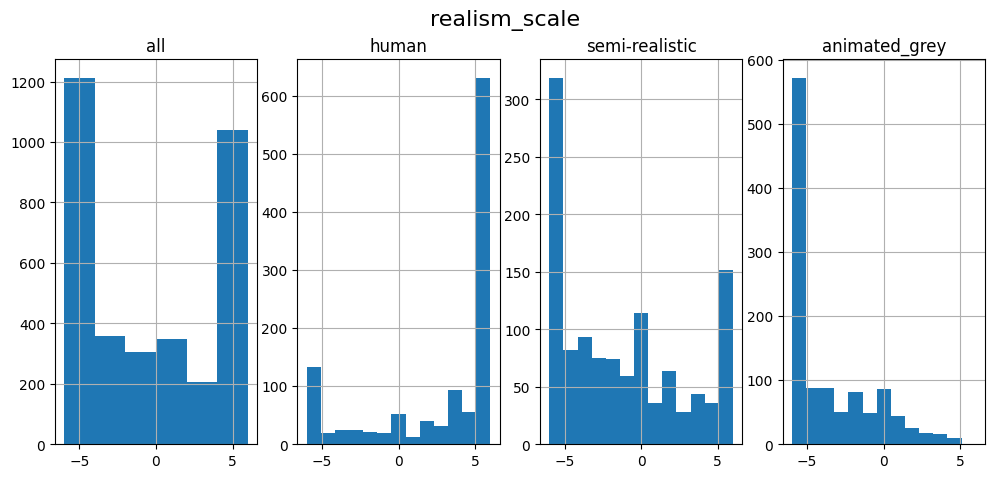

All: -2.00, Human: 6.00, Semi Realistic: -2.00, Cartoon: -6.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


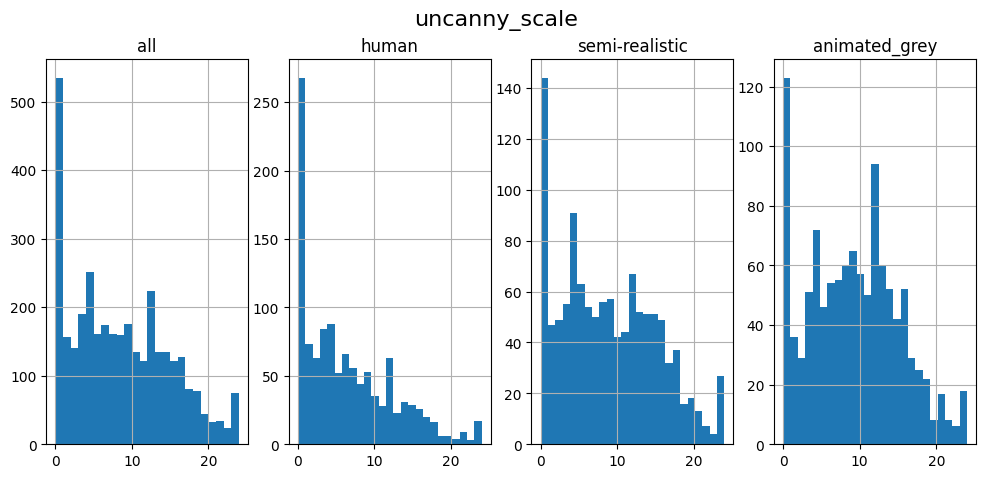

All: 7.00, Human: 5.00, Semi Realistic: 8.00, Cartoon: 9.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


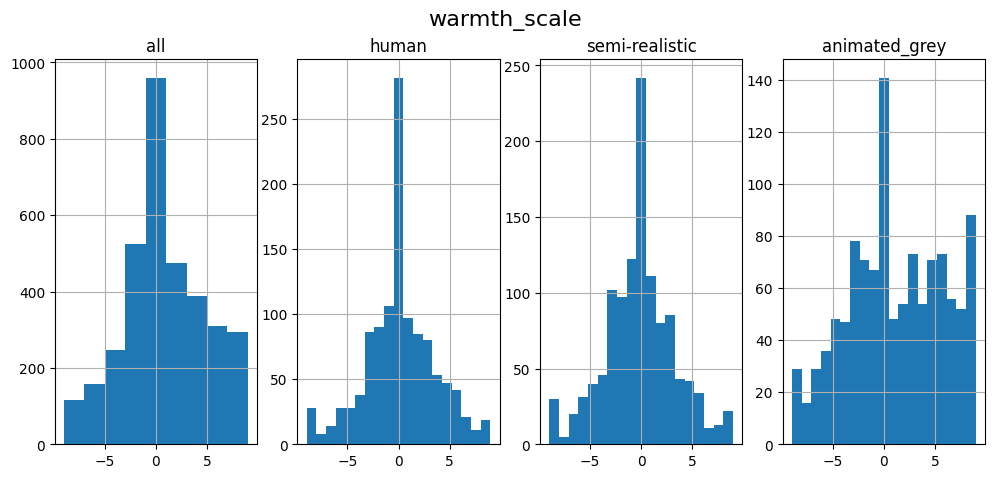

All: 0.00, Human: 0.00, Semi Realistic: 0.00, Cartoon: 1.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [85]:
ratings["realism_scale"] = ratings["Fictional/Real"] + ratings["Human-made/Human-like"]
ratings["uncanny_scale"] = ratings["Eerie/Ordinary"] + ratings["Unsettling/Plain"] + ratings[
    "Creepy/Dull"] + ratings["Hair-raising/Unemotional"]
ratings["warmth_scale"] = ratings["Hostile/Friendly"] + ratings["Grumpy/Cheerful"] + ratings[
    "Cold-hearted/Warm-hearted"]

for column in ["realism_scale", "uncanny_scale", "warmth_scale"]:
    analyse_columns(column, ratings)

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_26633/4286937560.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()


Text(0, 0.5, 'uncanny_scale')

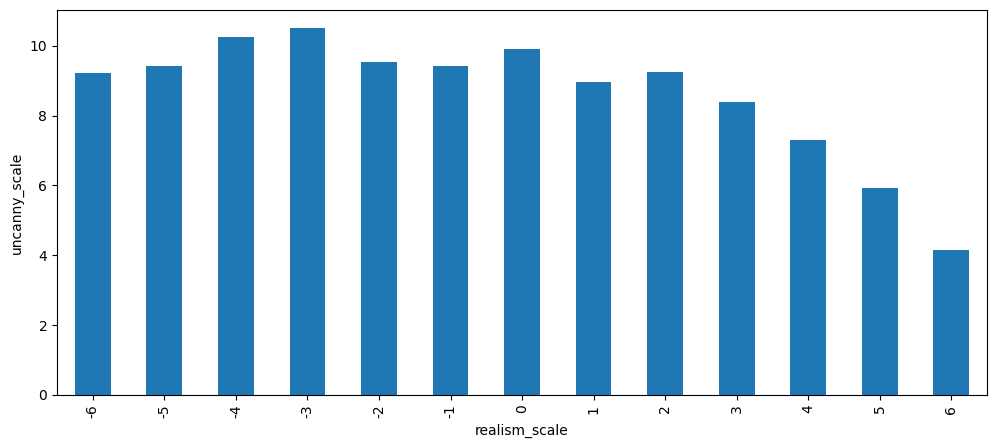

In [86]:
ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()
plt.ylabel("uncanny_scale")

In [87]:
stable_cohort_size = 108

stable_images = ratings.groupby("img").std().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:stable_cohort_size]
stable_ratings = ratings[ratings["img"].isin(stable_images)]

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_26633/143416688.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stable_images = ratings.groupby("img").std().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:stable_cohort_size]


# Best Images for the EEG Experiment

In [88]:
cohort_size = 20
best_images = pd.concat([
    stable_ratings[stable_ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale",
                                                                          ascending=True).reset_index()["img"][
    :cohort_size],
    stable_ratings[stable_ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale",
                                                                                   ascending=False).reset_index()[
        "img"][:cohort_size],
    stable_ratings[stable_ratings["type"] == "animated_grey"].groupby("img").mean().sort_values(by="uncanny_scale",
                                                                                  ascending=True).reset_index()["img"][
    :cohort_size]
]).to_list()
top_ratings = stable_ratings[stable_ratings["img"].isin(best_images)]

top_ratings.groupby(["filename", "type", "img"]).mean().to_csv("../export/best_dataset.csv")

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_26633/114512043.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stable_ratings[stable_ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale",
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_26633/114512043.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stable_ratings[stable_ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale",
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_26633/114512043.py:9: FutureWarning: The default value of numeric_only in DataFrameG

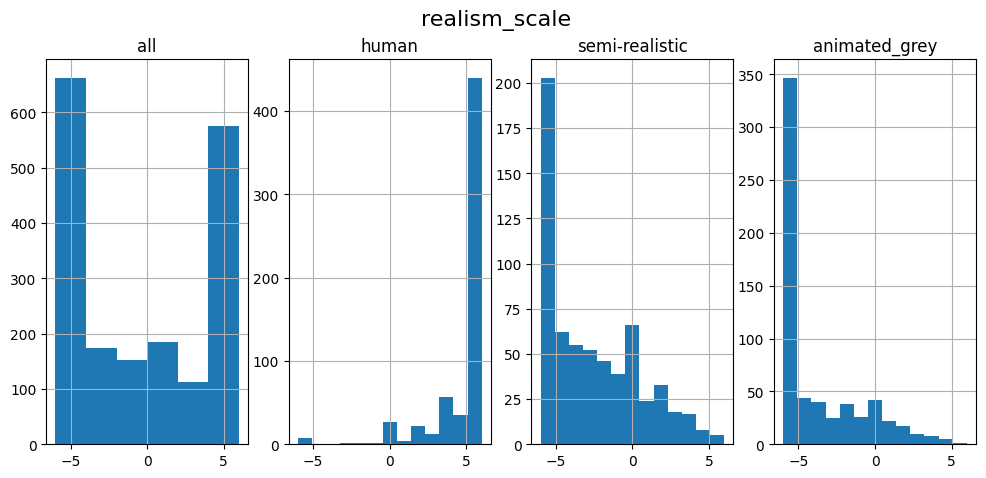

All: -1.00, Human: 6.00, Semi Realistic: -4.00, Cartoon: -6.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


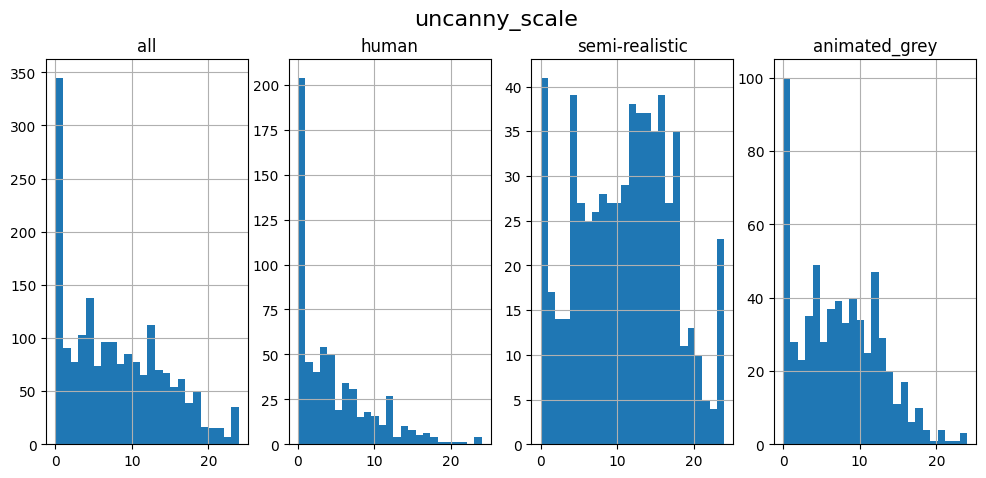

All: 7.00, Human: 3.00, Semi Realistic: 11.50, Cartoon: 7.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


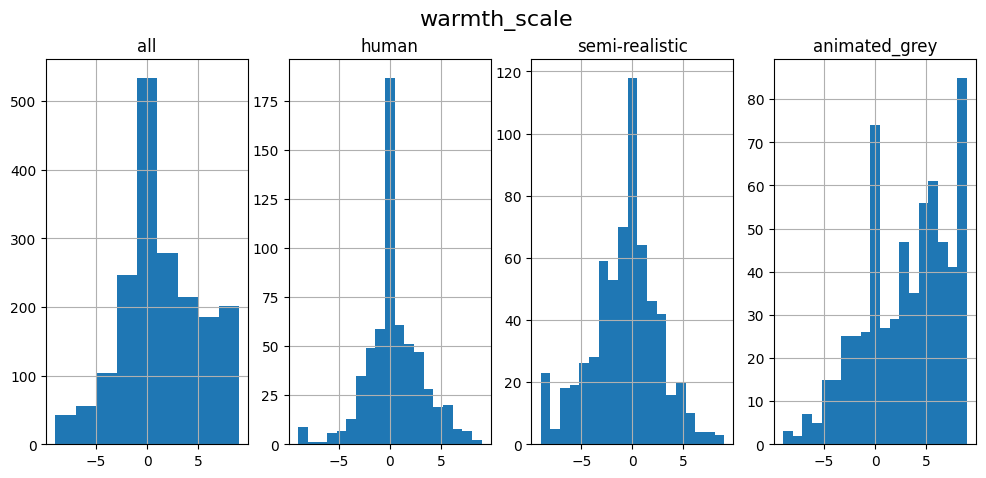

All: 0.00, Human: 0.00, Semi Realistic: 0.00, Cartoon: 4.00, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [89]:
for column in ["realism_scale", "uncanny_scale", "warmth_scale"]:
    analyse_columns(column, top_ratings)

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_26633/3368236120.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()


Text(0, 0.5, 'uncanny_scale')

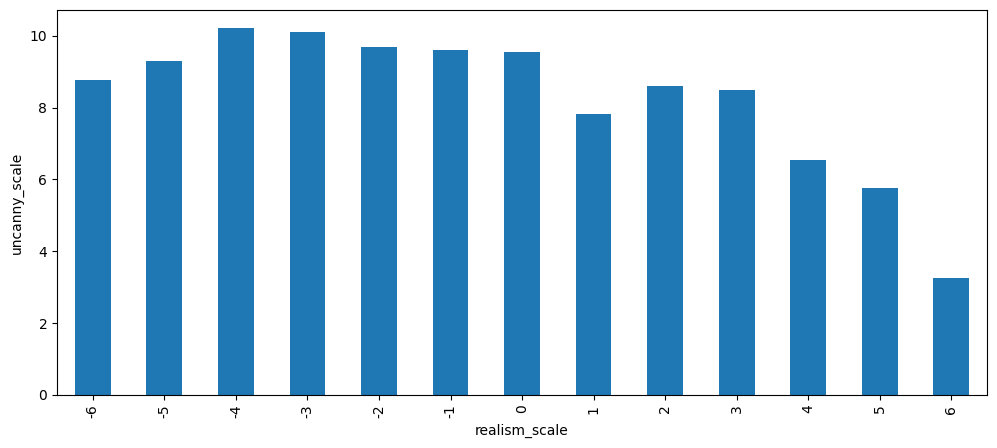

In [90]:
top_ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()
plt.ylabel("uncanny_scale")